# Exploring A Medical History of British India
Created in July-September 2020 for the National Library of Scotland's Data Foundry by Lucy Havens, Digital Library Research Intern

### About the *A Medical History of British India* Dataset
The dataset consists of 468 official publications from British India, mainly from 1850-1950, that report on public health, disease mapping, vaccination efforts, veterinary experiments, and other medical topics.  The publications are a subset of a larger collection of 40,000 volumes that report on the administration of British India.  The Wellcome Trust funded the digitisation of the medical history volumes in this dataset.
* Data format: digitised text
* Data creation process: Optical Character Recognition (OCR) and manual cleaning
* Data source: https://data.nls.uk/data/digitised-collections/a-medical-history-of-british-india/
***
### Table of Contents
0. [Preparation](#0.-Preparation)
1. [Data Cleaning and Standardisation](#1.-Data-Cleaning-and-Standardisation)
2. [Summary Statistics](#2.-Summary-Statistics)
3. [Exploratory Analysis](#3.-Exploratory-Analysis)
***

### 0. Preparation

Import libraries to use for cleaning, summarising and exploring the data:

In [20]:
# To prevent SSL certificate failure
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)):
    ssl._create_default_https_context = ssl._create_unverified_context

# Libraries for data loading
import pandas as pd
import numpy as np
import string
import re

# Libraries for visualization
import altair as alt
import matplotlib.pyplot as plt

# Libraries for text analysis
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')
from nltk.corpus import PlaintextCorpusReader
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.text import Text
from nltk.stem.porter import PorterStemmer
from nltk.probability import FreqDist
nltk.download('averaged_perceptron_tagger')
from nltk.tag import pos_tag
nltk.download('tagsets')  # part of speech tags
from nltk.draw.dispersion import dispersion_plot as displt

To explore the text in the *A Medical History of British India* collection, we'll mainly use the **Natural Language Toolkit (NLTK)**, a library written for the programming language Python.

The nls-text-indiaPapers folder (downloadable as *Just the text* data from the website at the top of this notebook) contains TXT files of digitised text with numerical names, as well as a CSV inventory file and a TXT ReadMe file.  Load only the TXT files of digitised text and **tokenise** the text (which splits a string into separate words and punctuation):

In [2]:
corpus_folder = 'data/nls-text-indiaPapers/'
wordlists = PlaintextCorpusReader(corpus_folder, '\d.*', encoding='latin1')
corpus_tokens = wordlists.words()
print(corpus_tokens[:10])

['No', '.', '1111', '(', 'Sanitary', '),', 'dated', 'Ootacamund', ',', 'the']


*Note: If you'd like to see how to specify a single TXT file to load as data, check out the Jupyter Notebook for the Britain and UK Handbooks!*

It's hard to get a sense of how accurately the text has been digitised from this list of 10 tokens, so let's look at one of these words in context.  To see phrases in which "India" is used, we can use the `concordance()` method:

In [3]:
t = Text(corpus_tokens)
t.concordance('India', lines=20)  # by default NLTK's concordance method displays 25 lines

Displaying 20 of 16495 matches:
ffg . Secretary to the Government of India . Resolution of Government of India 
 India . Resolution of Government of India No . 1 - 137 , dated 5th March 1875 
rch 1875 . Letter from Government of India No . 486 , dated 5th September 1876 
ember 1876 . Letter to Government of India No . 1063 , dated 26th ditto . REFER
ffg . Secretary to the Government of India , Home Department . REFERRING to par
 to paragraph 8 of the Government of India ' s Resolu - tion No . 1 - 136 , dat
inion expressed by the Government of India that any measures of segragation and
filth with which all the villages in India are surrounded is quite sufficient t
the disease in Rajputana and Central India are in the hands of the Presidency S
ffg . Secretary to the Government of India , Home Dept . IN continuation of my 
 the Resolution of the Government of India , Home Department ( Medical ), No 1 
d by the orders of the Government of India dated 5th March 1876 . Report on lep
e to the

The *A Medical History of British India* (MHBI) dataset has been digitised and then manually corrected for errors in the digitisation process, so we can be pretty confident in the quality of the text for this dataset.

Let's find out just how much text and just how many files we're working with:

In [22]:
def corpusStatistics(plaintext_corpus_read_lists):
    total_chars = 0
    total_tokens = 0
    total_sents = 0
    total_files = 0
    for fileid in plaintext_corpus_read_lists.fileids():
        total_chars += len(plaintext_corpus_read_lists.raw(fileid))
        total_tokens += len(plaintext_corpus_read_lists.words(fileid))
        total_sents += len(plaintext_corpus_read_lists.sents(fileid))
        total_files += 1
    print("Total...")
    print("  Characters in Medical History of British India (MHBI) Data:", total_chars)
    print("  Tokens in MHBI Data:", total_tokens)
    print("  Sentences in MHBI Data:", total_sents)
    print("  Files in MHBI Data:", total_files)

corpusStatistics(wordlists)

Total...
  Characters in Medical History of British India (MHBI) Data: 122297870
  Tokens in MHBI Data: 28333479
  Sentences in MHBI Data: 1671768
  Files in MHBI Data: 468


Note that I've print ``Tokens`` rather than words, though the NLTK method used to count those was ``.words()``.  This is because words in NLTK include punctuation marks and digits, in addition to alphabetic words.

The `fileids` are the names of the files in the data's source folder:

In [5]:
fileids = list(wordlists.fileids())
fileids[0:3]

['74457530.txt', '74457800.txt', '74458285.txt']

We can use the inventory CSV file from the source folder to match the titles of the papers to the corresponding `fileid`:

In [6]:
df = pd.read_csv('data/nls-text-indiaPapers/indiaPapers-inventory.csv', header=None, names=['fileid', 'title'])
df.head()  # prints the first 5 rows (df.tail() prints the last 5 rows)

,fileid,title
0,74457530.txt,Distribution and causation of leprosy in Briti...
1,74457800.txt,"Report of an outbreak of cholera in Suhutwar, ..."
2,74458285.txt,Report of an investigation into the causes of ...
3,74458388.txt,Account of plague administration in the Bombay...
4,74458575.txt,Inquiry into the circumstances attending an ou...


We can also create a list of the titles from the dataframe column:

In [7]:
titles = list(df['title'])
titles[0:3]   # Display the first three titles (from index 0 up to but not including index 3)

['Distribution and causation of leprosy in British India 1875 - IP/HA.2',
 'Report of an outbreak of cholera in Suhutwar, Bulliah sub-division - IP/30/PI.2',
 'Report of an investigation into the causes of the diseases known in Assam as Kála-Azár and Beri-Beri - IP/3/MB.5']

Variables that store the characters, words, and sentences in our dataset will be useful for future analysis.  Let's create those now:

In [8]:
def getCharsWordsSents(plaintext_corpus_read_lists, fileids):
    all_chars = []
    chars_by_file = dict.fromkeys(fileids)
    all_words = []
    words_by_file = dict.fromkeys(fileids)
    all_words_lower = []
    words_lower_by_file = dict.fromkeys(fileids)
    all_sents = []
    sents_by_file = dict.fromkeys(fileids)
    for fileid in plaintext_corpus_read_lists.fileids():
        
        file_chars = plaintext_corpus_read_lists.raw(fileid)
        all_chars += [str(char).lower() for char in file_chars]
        chars_by_file[fileid] = all_chars
        
        file_words = plaintext_corpus_read_lists.words(fileid)
        all_words_lower += [str(word).lower() for word in file_words if word.isalpha()]
        words_lower_by_file[fileid] = all_words_lower
        all_words += [str(word) for word in file_words  if word.isalpha()]
        words_by_file[fileid] = all_words
        
        file_sents = sent_tokenize(plaintext_corpus_read_lists.raw(fileid))  #plaintext_corpus_read_lists.sents(fileid)
        all_sents += [str(sent) for sent in file_sents]
        sents_by_file[fileid] = all_sents
        
    return all_chars, chars_by_file, all_words, words_by_file, all_words_lower, words_lower_by_file, all_sents, sents_by_file
        
mhbi_chars, mhbi_file_chars, mhbi_words, mhbi_file_words, mhbi_words_lower, mhbi_file_lower_words, mhbi_sents, mhbi_file_sents = getCharsWordsSents(wordlists, fileids)

To make sure the function worked as expected, we can run some quick tests with the output lists and dictionaries:

In [9]:
print(mhbi_file_chars[fileids[100]][:10])
print(mhbi_file_words[fileids[355]][30:40])
print(mhbi_file_sents[fileids[-1]][-20:-10])
assert(len(mhbi_file_chars) == len(fileids))  # nothing prints if passes, error prints if doesn't pass

['n', 'o', '.', ' ', '1', '1', '1', '1', ' ', '(']
['Government', 'of', 'India', 'No', 'dated', 'March', 'Letter', 'from', 'Government', 'of']
['By Assistant Director of Public Health or District Health Officers.', 'By Inspectors of Vaccination or other Inspecting Officers.', 'By Assistant Director of Public Health or District Health Officers.', 'By Inspectors of Vaccination or other Inspecting Officers.', 'Primary.', 'Re- vaccina- tions.', 'Primary.', 'Re- vaccina- tions.', 'Primary.', 'Re- vaccina- tions.']


In [10]:
print(mhbi_chars[:100])
print(mhbi_words[6100:6120])
print(mhbi_sents[-5:])
assert(len(mhbi_words_lower) == len(mhbi_words))  # nothing prints if passes, error prints if doesn't pass

['n', 'o', '.', ' ', '1', '1', '1', '1', ' ', '(', 's', 'a', 'n', 'i', 't', 'a', 'r', 'y', ')', ',', ' ', 'd', 'a', 't', 'e', 'd', ' ', 'o', 'o', 't', 'a', 'c', 'a', 'm', 'u', 'n', 'd', ',', ' ', 't', 'h', 'e', ' ', '6', 't', 'h', ' ', 'o', 'c', 't', 'o', 'b', 'e', 'r', ' ', '1', '8', '7', '6', '.', ' ', 'f', 'r', 'o', 'm', '-', 't', 'h', 'e', ' ', 'h', 'o', 'n', 'o', 'u', 'r', 'a', 'b', 'l', 'e', ' ', 'w', '.', ' ', 'h', 'u', 'd', 'l', 'e', 's', 't', 'o', 'n', ',', ' ', 'c', 'h', 'i', 'e', 'f']
['can', 'be', 'de', 'fined', 'as', 'the', 'special', 'home', 'of', 'leprosy', 'And', 'the', 'same', 'remark', 'holds', 'good', 'of', 'all', 'districts', 'It']
['APPENDIX A.APPENDICES.', '43 APPENDIX B.44 APPENDICES.', 'APPENDIX B.APPENDICES.', '45 APPENDIX C.(46) APPENDIX D. GRAPHS SHOWING THE VACCINATIONS PERFORMED AND THE DEATHS FORM SMALL-POX IN BURMA (EXCLUDING BACKWARD TRACTS) SINCE THE YEAR 1922-23 [NLS note: a graphic appears here - see image of page] G.B.C.P.O.APPENDIX E. Diagram showin

Looking good!

### 1. Data Cleaning and Standardisation

Since the OCR has already been manually cleaned, we'll focus this section on identifying the roots of words and the parts of speech in sentences, rather than getting a sense of how many mistakes were made in the OCR process.

#### 1.1 Tokenisation

First let's create lists of strings from the NLTK tokens that we can use in future analysis:

In [11]:
str_tokens = [str(word) for word in corpus_tokens]
assert(type(str_tokens[0]) == str)  # quick test to make sure the output is as expected
print(str_tokens[0:10])

# Lowercase text
lower_str_tokens = [t.lower() for t in str_tokens]
print(lower_str_tokens[-10:])

# Exclude stop words (i.e. the, a, is) - note that the input text must be lowercased!
eng_stopwords = set(stopwords.words('english'))
no_stopwords = [t for t in lower_str_tokens if not t in eng_stopwords]
print(no_stopwords[500:510])
assert(len(no_stopwords) < len(str_tokens))

# Alphabetic tokens only (exclude digits and punctuation)
alpha_tokens = [t for t in str_tokens if t.isalpha()]
alpha_tokens_lower = [t for t in lower_str_tokens if t.isalpha()]
print(alpha_tokens[1000:1010])
assert(len(alpha_tokens_lower) == len(alpha_tokens))

['No', '.', '1111', '(', 'Sanitary', '),', 'dated', 'Ootacamund', ',', 'the']
['g', '.', 'b', '.', 'c', '.', 'p', '.', 'o', '.']
[',', '424', '705', '491', '214', '8', '11', '5', 'surat', '607']
['the', 'twenty', 'cases', 'mentioned', 'above', 'seventeen', 'are', 'said', 'to', 'have']


#### 1.2 Reducing Words to Root Forms
Next, we'll **stem** the tokens, or reduce the tokens to their root.  NLTK has two types of stemmers that use different algorithms to determine what the root of a word is.  Here's a sample of what they look like.

<div class="alert alert-block alert-warning">
    <b>Note:</b> This code can take several minutes to run, so you may wish to choose only one stemmer, which is why one of the stemmers has been commented out. You can uncomment the code so that it runs by removing the '#' before each line (highlight all lines and then press CMD + /).
</div>

In [12]:
# Stem the text (reduce words to their root, whether or not the root is a word itself
porter = nltk.PorterStemmer()
porter_stemmed = [porter.stem(t) for t in alpha_tokens_lower]
print(porter_stemmed[500:600])

# lancaster = nltk.LancasterStemmer()
# lancaster_stemmed = [lancaster.stem(t) for t in alpha_tokens_lower]
# print(lancaster_stemmed[500:600])

['the', 'govern', 'of', 'india', 'that', 'ani', 'measur', 'of', 'segrag', 'and', 'medic', 'treatment', 'of', 'leper', 'throughout', 'the', 'countri', 'would', 'be', 'impractic', 'as', 'a', 'state', 'measur', 'but', 'i', 'do', 'hold', 'that', 'the', 'improv', 'of', 'the', 'hygien', 'condit', 'under', 'which', 'the', 'mass', 'of', 'the', 'peopl', 'live', 'is', 'the', 'onli', 'sure', 'method', 'of', 'stamp', 'out', 'leprosi', 'or', 'ani', 'similar', 'diseas', 'the', 'filth', 'with', 'which', 'all', 'the', 'villag', 'in', 'india', 'are', 'surround', 'is', 'quit', 'suffici', 'to', 'prevent', 'ani', 'hope', 'of', 'success', 'in', 'combat', 'the', 'diseas', 'which', 'it', 'is', 'not', 'difficult', 'to', 'forese', 'will', 'prevail', 'until', 'such', 'an', 'objection', 'state', 'of', 'matter', 'is', 'alter', 'with', 'these']


Another approach to reducing words to their root is to **lemmatise** tokens.  NLTK's WordNet Lemmatizer reduces a token to its root *only* if the reduction of the token results in a word that's recognised as an English word in WordNet.  Here's what that looks like:

In [13]:
# Lemmatise the text (reduce words to their root ONLY if the root is considered a word in WordNet)
wnl = nltk.WordNetLemmatizer()
lemmatized = [wnl.lemmatize(t) for t in alpha_tokens_lower]  # only include alphabetic tokens
print(lemmatized[500:600])

['the', 'government', 'of', 'india', 'that', 'any', 'measure', 'of', 'segragation', 'and', 'medical', 'treatment', 'of', 'leper', 'throughout', 'the', 'country', 'would', 'be', 'impracticable', 'a', 'a', 'state', 'measure', 'but', 'i', 'do', 'hold', 'that', 'the', 'improvement', 'of', 'the', 'hygienic', 'condition', 'under', 'which', 'the', 'mass', 'of', 'the', 'people', 'live', 'is', 'the', 'only', 'sure', 'method', 'of', 'stamping', 'out', 'leprosy', 'or', 'any', 'similar', 'disease', 'the', 'filth', 'with', 'which', 'all', 'the', 'village', 'in', 'india', 'are', 'surrounded', 'is', 'quite', 'sufficient', 'to', 'prevent', 'any', 'hope', 'of', 'success', 'in', 'combating', 'the', 'disease', 'which', 'it', 'is', 'not', 'difficult', 'to', 'foresee', 'will', 'prevail', 'until', 'such', 'an', 'objectionable', 'state', 'of', 'matter', 'is', 'altered', 'with', 'these']


#### 1.3 Part of Speech Tagging

To study the linguistic style of text, analysing the **parts of speech** and their patterns in sentences can be useful.  NLTK has a method for tagging tokens with a part of speech in a sentence.  Let's do that too (note that this can take several minutes to run):

In [14]:
# Tag parts of speech in sentences
sentences = wordlists.sents()
pos_tagged = [nltk.pos_tag(sent) for sent in sentences]
print(pos_tagged[:10])

[[('No', 'DT'), ('.', '.')], [('1111', 'CD'), ('(', '('), ('Sanitary', 'NNP'), ('),', 'NNP'), ('dated', 'VBD'), ('Ootacamund', 'NNP'), (',', ','), ('the', 'DT'), ('6th', 'CD'), ('October', 'NNP'), ('1876', 'CD'), ('.', '.')], [('From', 'IN'), ('-', ':'), ('The', 'DT'), ('Honourable', 'JJ'), ('W', 'NNP'), ('.', '.'), ('HUDLESTON', 'NNP'), (',', ','), ('Chief', 'NNP'), ('Secretary', 'NNP'), ('to', 'TO'), ('the', 'DT'), ('Govern', 'NNP'), ('-', ':'), ('ment', 'NN'), ('of', 'IN'), ('Madras', 'NNP'), ('.', '.')], [('To', 'TO'), ('-', ':'), ('The', 'DT'), ('Offg', 'NNP'), ('.', '.')], [('Secretary', 'NNP'), ('to', 'TO'), ('the', 'DT'), ('Government', 'NNP'), ('of', 'IN'), ('India', 'NNP'), ('.', '.')], [('Resolution', 'NN'), ('of', 'IN'), ('Government', 'NNP'), ('of', 'IN'), ('India', 'NNP'), ('No', 'NNP'), ('.', '.')], [('1', 'CD'), ('-', ':'), ('137', 'CD'), (',', ','), ('dated', 'VBD'), ('5th', 'CD'), ('March', 'NNP'), ('1875', 'CD'), ('.', '.')], [('Letter', 'NN'), ('from', 'IN'), ('Gove

NLTK uses abbreviations to identify parts of speech, such as:
* `CD` = numeral, cardinal
* `DT` = determiner
* `JJ` = adjective
* `NN` = singular noun
* `RB` = adverb
* `VB` = verb

More abbreviations are explained [here](https://www.learntek.org/blog/categorizing-pos-tagging-nltk-python/) or can be queried with `nltk.help.upenn_tagset('TAG')` (replace `TAG` with the part-of-speech tag abbreviation of your choice).

### 2. Summary Statistics

#### 2.1 Frequencies and Sizes
Now that we've created some different cuts of the MHBI dataset, let's start investigating the frequency of terms as they appear across the dataset.  One way to do so is with a **frequency distribution**, which is a line chart that shows how many times a token appears in the dataset.

First let's visualise a frequency distribution for common alphabetical tokens in the dataset (tokens composed of letters, not punctuation or numbers) EXCEPT stop words (i.e. the, and, a):

In [15]:
# Filter one-letter words, two-letter words, and  stop words out of the list of alphabetic tokens
min_three_letters = [t for t in alpha_tokens_lower if len(t) > 2]
to_exclude = list(set(stopwords.words('english'))) + ["per", "two", "one", "also"]
filtered_tokens = [t for t in min_three_letters if not t in to_exclude]

In [16]:
# Calculate the frequency distribution for the filtered list of tokens
fdist_ft = FreqDist(filtered_tokens)
print("Total tokens in filtered list:", fdist_ft.N())

Total tokens in filtered list: 8526376


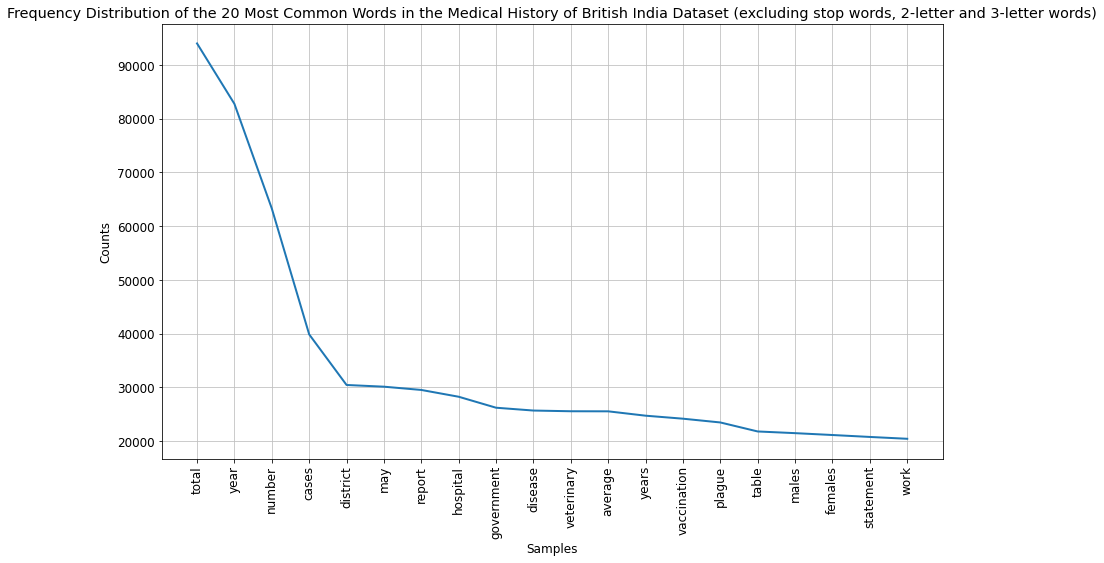

In [27]:
# Visualise the frequency distribution for a select number of tokens
plt.figure(figsize = (14, 8))                # customise the width and height of the plot
plt.rc('font', size=12)                       # customise the font size of the title, axes names, and axes labels
fdist_ft.plot(20, title='Frequency Distribution of the 20 Most Common Words in the Medical History of British India Dataset (excluding stop words, 2-letter and 3-letter words)')

The medical focus is clear from the top 20 words in the MHBI papers, which includes `cases`, `hospital`, `disease`, `veterinary`, `vaccination`, and `plague`.  Also, the frequency distribution suggests the people writing the papers made an effort to summarise what was going on, since the top three tokens, by far, are `total`, `year`, and `number` (perhaps summarising `cases` by `district`?).

Let's create a frequency distribution for *stemmed* words to see if differences arise in the distributions:

Total tokens in filtered list: 8720609


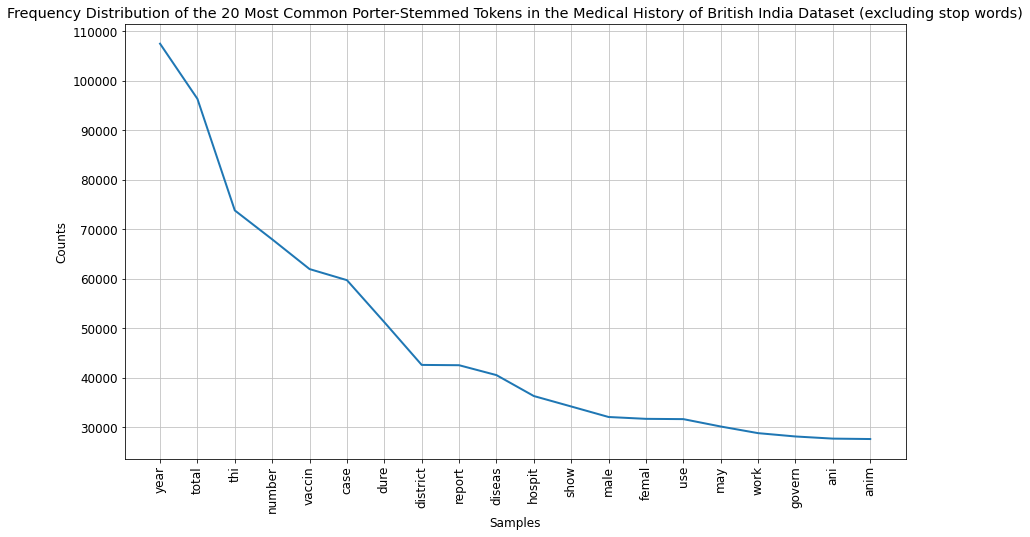

In [28]:
# Filter one-letter words, two-letter words, and  stop words out of the list of porter-stemmed tokens
min_three_letters = [s for s in porter_stemmed if len(s) > 2]
to_exclude = list(set(stopwords.words('english'))) + ["per", "two", "one", "also"]
filtered_pstems = [s for s in min_three_letters if not s in to_exclude]
# Calculate the frequency distribution for the filtered list of tokens
fdist_ps = FreqDist(filtered_pstems)
print("Total tokens in filtered list:", fdist_ps.N())
# Visualise the frequency distribution for a select number of tokens
plt.figure(figsize = (14, 8))                # customise the width and height of the plot
plt.rc('font', size=12)                       # customise the font size of the title, axes names, and axes labels
fdist_ps.plot(20, title='Frequency Distribution of the 20 Most Common Porter-Stemmed Tokens in the Medical History of British India Dataset (excluding stop words)')

The slope of the frequency distribution line isn't quite so steep when we look at word stems (using the Porter Stemmer, in this case).  This gives us a better sense of how often a topic appears, such as anything to do with vaccines, rather than a specific form of a word, such as vaccination.  The stem `vaccin` occurs with much higher frequency (about 60,000 times) than in the previous two charts (which record its frequency of occurrences at about 25,000 and 30,000 times).  What other differences can you spot?

#### 2.2 Uniqueness and Variety

Another way to summarise the MHBI dataset is to look at the uniqueness and variety of word usage.  We can obtain the **vocabulary** of the text by creating a set of unique words (alphabetic tokens) that occur in the dataset, as well as creating a set of unique *lemmatised* words that occur in the dataset.

In [ ]:
# Remove duplicate words from the text (obtain the vocabulary of the text)
t_vocab = set(alpha_tokens)
t_vocab_lower = set(alpha_tokens_lower)
lemma_vocab = set(lemmatised)
print("Unique tokens:", len(t_vocab))
print("Unique lowercase tokens:", len(t_vocab_lower))
print("Unique lemmatised (lowercase) tokens:", len(lemma_vocab))

We can create a data visualisation that illustrates when specific words are used within the MHBI dataset.  This is called a **Lexical Dispersion Plot**.  We'll pick some terms (the list of `targets`) from the list of the most common 20 words in the dataset:

In [29]:
fdist_ft.most_common(20)

[('total', 94009),
 ('year', 82764),
 ('number', 63297),
 ('cases', 39875),
 ('district', 30462),
 ('may', 30145),
 ('report', 29538),
 ('hospital', 28273),
 ('government', 26231),
 ('disease', 25705),
 ('veterinary', 25575),
 ('average', 25560),
 ('years', 24749),
 ('vaccination', 24190),
 ('plague', 23489),
 ('table', 21813),
 ('males', 21500),
 ('females', 21153),
 ('statement', 20794),
 ('work', 20452)]

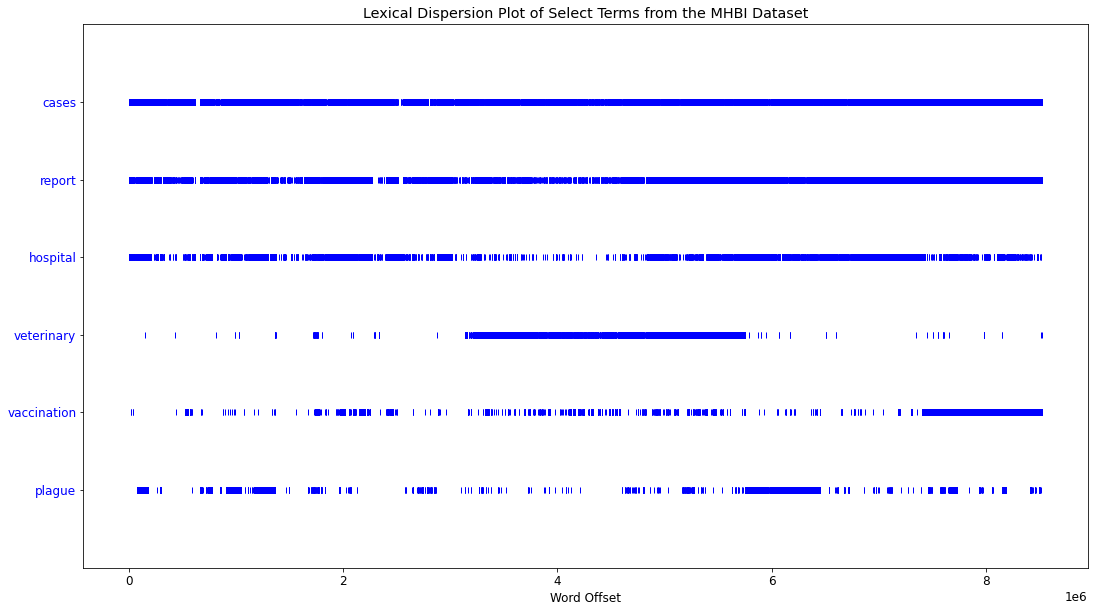

In [31]:
corpus_text = Text(filtered_tokens)
targets = ['cases', 'report', 'hospital', 'veterinary', 'vaccination', 'plague']
plt.figure(figsize=(18,10))
plt.rc('font', size=12)
displt(corpus_text, targets, ignore_case=True, title='Lexical Dispersion Plot of Select Terms from the MHBI Dataset')

### 3. Exploratory Analysis

Let's determine the top 20 most common words for each paper (file) in the MHBI dataset:

In [41]:
fileids = list(df['fileid'])
id_to_title = dict(zip(fileids,titles))

In [42]:
common_words = {}
for file in fileids:
    tokens = wordlists.words(file)

    # Filter non-alphabetic words and stop words out of the list of tokens
    tokens_lower = [t.lower() for t in tokens if t.isalpha()]
    to_exclude = list(set(stopwords.words('english'))) + ["per", "two", "one", "also"]
    filtered_tokens = [t for t in tokens_lower if not t in to_exclude]
    
    fdist = FreqDist(filtered_tokens)
    
    title = id_to_title[file]
    words = list(fdist.most_common(20))
    common_words[title] = words

print(len(common_words))

465


Now you can use the title of a paper to find the 20 most common words in that paper:

In [62]:
paper = id_to_tile[fileids[10]]
print(common_words[paper])

[('microbe', 26), ('mr', 15), ('hankin', 14), ('plague', 14), ('bubo', 14), ('h', 13), ('found', 12), ('action', 10), ('l', 9), ('acid', 8), ('infection', 7), ('infected', 7), ('days', 7), ('e', 7), ('rt', 7), ('pneumonia', 7), ('water', 6), ('rec', 6), ('fem', 6), ('b', 6)]


<div class='alert alert-block alert-info'>
    <b>Try It!</b> Inspired by questions from MHBI's curator, the questions below offer starting points for topics you could consider exploring in the MHBI dataset!
</div>

#### 3.1 Which publications are about cholera?  Leprosy?  Malaria?  Plague?  Laboratory medicine?

In [66]:
t.concordance("cholera")

Displaying 25 of 8913 matches:
son who died at 5 years of age from cholera . Ansthetic leprosy of 15 years ' s
f the squamous Goitre rarely seen , cholera variety are very common . breaks ou
reaks out in epidemics , Goitre and cholera are endemic . but does not exist th
 the same sense as typhoid fever or cholera is contagious , though not to the s
use 40 1 Police 454 1 Four outlying cholera - infected villages were recently v
disease . Father and mother died of cholera . Is living with an uncle . Has no 
e , reporting a serious outbreak of cholera in the town of Suhutwar , in the Bu
fect that 300 persons had died from cholera at this place , but in a subsequent
 5 . Placed in this position , with cholera " raging furiously , " the Magistra
rules in those vil - lages in which cholera may become epidemic ." 6 . In his c
rn - ment whether , in the event of cholera continuing to prevail at Suhutwar ,
asonably hope that before that time cholera will have dis - appeared . Should i
eceived a

#### 3.2 How does the language around the people of India change over time?

Consider comparing papers from before and after the 1857 rebellion when British East India Company rule in India was taken over by the British Crown.  How does the word choice and sentiment of the language differ before and after?

In [65]:
t.concordance("Native")

Displaying 25 of 12589 matches:
 suffered from this disease , was a native of the territory beyond the Hubb . 
ourhood . NEEMUCH . 24th Regiment , Native Infantry , no leprosy . 3rd Queen '
es reported from Meerut is one of a Native Chris - tian employed in the Missio
 he had continued to cohabit with a Native woman after she had been attacked w
was only visited rarely by the Jail Native Doctor , to whom an allowance of Rs
The patient was 25 years of age , a native of Lucknow , and a pilgrim from Jug
ase No . II .- Ukul , a Mussalman , native of Hazaribagh , aged thirteen years
III .- Kally Dass , aged twenty , a native of Lucknow and a pilgrim , admitted
emale , married , aged 30 years , a native of Gya , admitted as an out - patie
 V .- Ahmed Ali , aged 35 years , a native of Hazaribagh , admitted as an out 
ted with mercury by kobirajes . The Native Doctor in charge of the Ghattal Dis
 1877 . From - Babu RAJCUMAR Doss , Native Doctor in charge of Ghattal Dis - p
ous administration o

#### 3.3 How does the language around mental hospitals change over time?

In [43]:
t.concordance("lunatic")

Displaying 25 of 8704 matches:
f charas or ganja per diem became a lunatic ; he was harmless and has disappear
was in medical charge of the Madras Lunatic Asylum for five years , and during 
rience as medical officer of Colaba Lunatic Asylum , I can say that I have seen
intendent of the Madras and Waltair Lunatic Asylums for a lengthened period , I
lent , and was ultimately sent to a lunatic asylum . He had previously shown sy
ts consumers are in the end sent to lunatic asylums . When a consumer has no mo
d the next - door neighbours of the lunatic , agree in saying that Salik Patick
adh , the chaukidar who brought the lunatic to the authorities , is responsible
cause , and the state - ment of the lunatic , which gives ganja as the drug he 
 . The only witness examined is the lunatic ' s brother , he , Maghan Gir , bei
EMP DRUG CASES OF 1892 . 47 , DACCA LUNATIC ASYLUM . ( SUPERINTENDENT , DR . CO
strict , age and register number of lunatic . Alleged cause of insanity . ( Sta
 HEMP DRU

In [44]:
t.concordance("mental")

Displaying 25 of 5384 matches:
onkeys that I obtained for experi - mental purposes , five months ago , positi
th seriously affected by the severe mental and physical strain to which it had
ent , and this is followed by utter mental depression , and they are also subj
ak in the station . He thought that mental dejection had something to say to t
ium . In cases marked by stupor the mental faculties appeared to be paralysed 
 a rule their muscular strength and mental energy ; and buboes are very rarely
rmal temperature , and considerable mental excitement ; or in a later stage dr
 tenderness is present . Cerebral , mental , vaso - motor and nutritive functi
 the drug by persons suffering from mental anxiety or brain disease to obtain 
No . 1 . 20 . Total strength2 Yes . Mental anxiety or brain disease has been s
 smoking produces irritation of the mental power to those who do not take nour
nsanity , but it rather excites the mental power by its long - standing use . 
hitis , men - tal det

#### 3.4 How are women portrayed?

Consider lock(ed) hospitals and escapes from them, and prostitution permitted in army barracks.

In [51]:
t.concordance("women")

Displaying 25 of 4232 matches:
much more prevalent amongst men than women . The census statement is 8 , 160 ma
g 68 28 Lawyers , clerks , brokers 7 women or children ). 29 Dyers 5 6 Beggars 
irly numerous , and at which men and women are often fertile in this country , 
ecially of men as distinguished from women . A disease not peculiar to persons 
ectation of help from relations than women ) have fallen into misery and povert
, fell in love with one of the leper women and kept company with her for some t
mong men and boys than it does among women and girls ; the proportion of the ma
e seen more lepers among men than in women , and more among Muhammadans than am
t out . Then again a large number of women afflicted with the disease eluded th
curately ascertain the proportion of women thus left out , as I am certain the 
m certain the cases of young married women were not shown me by the people . If
epers I have taken notes of 125 were women . I assume , then , from the census 
servants 

In [64]:
t.concordance("lock")

Displaying 25 of 2289 matches:
 Hospital Assistant in charge of the lock hospital was appointed to take medic
ar the balance of ganja under double lock is verified by the tahsildar by actu
epared to say that Government should lock up all lunatics . I have seen the pa
parties , If a room was locked , the lock was opened by the locksmith , a Poli
rt . There it is placed under double lock , one being in the possession of the
t he should also be in charge of the Lock Hospital . One of his chief duties w
ooden box for inoculation kit , with lock 1 Contents of box . 1 Inoculation sy
asy chairs , 1 meatsafe , 1 box with lock and key for stores , 1 table lamp , 
or drugs and appliances , 1 box with lock and key for poisons , 1 dispensing t
 friends have even gone so far as to lock their sick up in large wooden chests
ndicated . Like opium , they tend to lock up secretions , on the restoration o
very first act would be to carefully lock up all brandy , wine , and similar s
re 1 2 3 Sappers to e

#### 3.5 What is the rhetoric around vaccinations and, more generally, public health?

In [54]:
t.concordance("vaccination")

Displaying 25 of 24190 matches:
 Inoculation or by cohabitation . Vaccination . Attributable to syphilis and us
 Inoculation or by cohabitation . Vaccination . Attributable to syphilis and us
e course of his frequent tours on vaccination work he has met with very few suf
for instance by inoculation or by vaccination ; that it is curable in slight ca
estion 45 . 315 Superintendent of Vaccination , Eastern Bengal Circle ; Deputy 
oncld . Leprosy not maintained by vaccination - Lepers never assign this as the
g transmitted by vaccina - tion - Vaccination returns - Vaccination becoming mo
na - tion - Vaccination returns - Vaccination becoming more popular and leprosy
- Between man and wife - Tables - Vaccination - Experiments by Commission - Spr
it was practised in preference to vaccination . Inoculation for small - pox in 
all , or 2 . 0 to each marriage . Vaccination undergone by . . . . 7 Inoculatio
surroundings . ( 45 ) Leprosy and Vaccination , by W . \ ill \. ( 46 ) Op . cit
om outly